# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [7]:
%load_ext autoreload
%autoreload 2
import keras
from datetime import datetime
import os, time
import pathlib
from usl_models.atmo_ml.model import AtmoModel, AtmoModelParams
from usl_models.atmo_ml import dataset, visualizer, constants, vars
from google.cloud import storage

import logging

logging.getLogger().setLevel(logging.INFO)

# climateiq-study-area-feature-chunks/NYC_Heat/NYC_summer_2000_01p
# Define bucket names and folder paths
data_bucket_name = "climateiq-study-area-feature-chunks"
label_bucket_name = "climateiq-study-area-label-chunks"
time_steps_per_day = 6
batch_size = 4

sim_dirs = [
    (
        "NYC_Heat_Test",
        [
            "NYC_summer_2000_01p",
            # 'NYC_summer_2010_99p',
            # 'NYC_summer_2015_50p',
            # 'NYC_summer_2017_25p',
            # 'NYC_summer_2018_75p'
        ],
    ),
    (
        "PHX_Heat_Test",
        [
            # 'PHX_summer_2008_25p',
            # 'PHX_summer_2009_50p',
            # 'PHX_summer_2011_99p',
            # 'PHX_summer_2015_75p',
            # 'PHX_summer_2020_01p'
        ],
    ),
]

sim_names = []
for sim_dir, subdirs in sim_dirs:
    for subdir in subdirs:
        sim_names.append(sim_dir + "/" + subdir)

print(sim_names)
client = storage.Client(project="climateiq")
feature_bucket = client.bucket(data_bucket_name)
label_bucket = client.bucket(label_bucket_name)
output_vars = [
    vars.SpatiotemporalOutput.RH2
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['NYC_Heat_Test/NYC_summer_2000_01p']


In [8]:
train_frac = 0.8

sim_name = "NYC_Heat_Test/NYC_summer_2000_01p"
date = "2000-05-25"

# Create training dataset with fused spatiotemporal data
train_ds = dataset.load_dataset_cached(
    pathlib.Path("data/filecache"),
    example_keys=[("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25")],
    output_vars=output_vars,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    pathlib.Path("data/filecache"),
    example_keys=[("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25")],
    output_vars=output_vars,
).batch(batch_size=batch_size)

In [9]:
# Initialize the Atmo Model
model_params = AtmoModelParams(output_vars=output_vars)
model = AtmoModel(model_params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  488       
                                                                 
 spatial_cnn (Sequential)    (None, 50, 50, 128)       252992    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_4 (Conv2D)          (None, 100, 100, 64)      48064    |
|                                                               |
| max_pooling2d_4 (MaxPooli  (None, 100, 100, 64)      0        |
| ng2D)                                                         |
|                                                               |
| conv2d_5 (Conv2D)          (None, 50, 50, 128)       204928   |
|                                                               |
| max_pooling2d_5 (MaxPooli  (None, 50, 50, 128)       0        |
| ng2D)                                           

In [10]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=50, callbacks=[tb_callback], validation_freq=10)

./logs/run_20250128-213001
Epoch 1/50


2025-01-28 21:30:05.358376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/atmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
INFO:root:Total generated samples: 1


1/1 [==============================] - 6s 6s/step - loss: 5400.2671 - mean_absolute_error: 69.5631 - root_mean_squared_error: 73.4865
Epoch 2/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 5342.7734 - mean_absolute_error: 69.1488 - root_mean_squared_error: 73.0943
Epoch 3/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 5266.6030 - mean_absolute_error: 68.5951 - root_mean_squared_error: 72.5714
Epoch 4/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 5156.9976 - mean_absolute_error: 67.7907 - root_mean_squared_error: 71.8122
Epoch 5/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 5015.7729 - mean_absolute_error: 66.7383 - root_mean_squared_error: 70.8221
Epoch 6/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 4839.8228 - mean_absolute_error: 65.4025 - root_mean_squared_error: 69.5688
Epoch 7/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 4625.1753 - mean_absolute_error: 63.7335 - root_mean_squared_error: 68.0086
Epoch 8/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 4372.1382 - mean_absolute_error: 61.7063 - root_mean_squared_error: 66.1221
Epoch 9/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 4075.7683 - mean_absolute_error: 59.2458 - root_mean_squared_error: 63.8417
Epoch 10/50


INFO:root:Total generated samples: 1


1/1 [==============================] - ETA: 0s - loss: 3741.3596 - mean_absolute_error: 56.3382 - root_mean_squared_error: 61.1667

INFO:root:Total generated samples: 1


1/1 [==============================] - 3s 3s/step - loss: 3741.3596 - mean_absolute_error: 56.3382 - root_mean_squared_error: 61.1667 - val_loss: 3370.2649 - val_mean_absolute_error: 52.9224 - val_root_mean_squared_error: 58.0540
Epoch 11/50


2025-01-28 21:30:19.798227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 477382439996860711
2025-01-28 21:30:19.798279: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13403503870952125127
2025-01-28 21:30:19.798290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6840463366771044700
2025-01-28 21:30:19.798311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10017643975518696676
INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 3370.2764 - mean_absolute_error: 52.9225 - root_mean_squared_error: 58.0541
Epoch 12/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 2966.6348 - mean_absolute_error: 48.9403 - root_mean_squared_error: 54.4668
Epoch 13/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 2520.8416 - mean_absolute_error: 44.2536 - root_mean_squared_error: 50.2080
Epoch 14/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 2047.3336 - mean_absolute_error: 39.1296 - root_mean_squared_error: 45.2475
Epoch 15/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 1566.6095 - mean_absolute_error: 33.9885 - root_mean_squared_error: 39.5804
Epoch 16/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 1121.0721 - mean_absolute_error: 29.0279 - root_mean_squared_error: 33.4824
Epoch 17/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 753.9153 - mean_absolute_error: 23.9432 - root_mean_squared_error: 27.4575
Epoch 18/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 590.2979 - mean_absolute_error: 20.9773 - root_mean_squared_error: 24.2960
Epoch 19/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 601.3899 - mean_absolute_error: 19.9039 - root_mean_squared_error: 24.5233
Epoch 20/50


INFO:root:Total generated samples: 1


1/1 [==============================] - ETA: 0s - loss: 769.4613 - mean_absolute_error: 20.9802 - root_mean_squared_error: 27.7392

INFO:root:Total generated samples: 1


1/1 [==============================] - 2s 2s/step - loss: 769.4613 - mean_absolute_error: 20.9802 - root_mean_squared_error: 27.7392 - val_loss: 975.3166 - val_mean_absolute_error: 23.2342 - val_root_mean_squared_error: 31.2301
Epoch 21/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 975.0512 - mean_absolute_error: 23.2327 - root_mean_squared_error: 31.2258
Epoch 22/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 1103.5780 - mean_absolute_error: 24.8932 - root_mean_squared_error: 33.2201
Epoch 23/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 1113.1892 - mean_absolute_error: 24.9456 - root_mean_squared_error: 33.3645
Epoch 24/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 1035.5194 - mean_absolute_error: 23.8351 - root_mean_squared_error: 32.1795
Epoch 25/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 903.9971 - mean_absolute_error: 22.2265 - root_mean_squared_error: 30.0665
Epoch 26/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 768.4015 - mean_absolute_error: 20.9379 - root_mean_squared_error: 27.7201
Epoch 27/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 658.7352 - mean_absolute_error: 20.3085 - root_mean_squared_error: 25.6658
Epoch 28/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 592.1296 - mean_absolute_error: 20.2535 - root_mean_squared_error: 24.3337
Epoch 29/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 570.0310 - mean_absolute_error: 20.5292 - root_mean_squared_error: 23.8753
Epoch 30/50


INFO:root:Total generated samples: 1


1/1 [==============================] - ETA: 0s - loss: 577.6535 - mean_absolute_error: 20.9784 - root_mean_squared_error: 24.0344

INFO:root:Total generated samples: 1


1/1 [==============================] - 2s 2s/step - loss: 577.6535 - mean_absolute_error: 20.9784 - root_mean_squared_error: 24.0344 - val_loss: 603.6781 - val_mean_absolute_error: 21.5609 - val_root_mean_squared_error: 24.5699
Epoch 31/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 603.6957 - mean_absolute_error: 21.5611 - root_mean_squared_error: 24.5702
Epoch 32/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 634.8493 - mean_absolute_error: 22.1381 - root_mean_squared_error: 25.1962
Epoch 33/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 662.6262 - mean_absolute_error: 22.6184 - root_mean_squared_error: 25.7415
Epoch 34/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 680.9893 - mean_absolute_error: 22.9261 - root_mean_squared_error: 26.0958
Epoch 35/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 687.3222 - mean_absolute_error: 23.0338 - root_mean_squared_error: 26.2168
Epoch 36/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 680.7703 - mean_absolute_error: 22.9238 - root_mean_squared_error: 26.0916
Epoch 37/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 664.5766 - mean_absolute_error: 22.6560 - root_mean_squared_error: 25.7794
Epoch 38/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 639.6536 - mean_absolute_error: 22.2347 - root_mean_squared_error: 25.2914
Epoch 39/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 614.1046 - mean_absolute_error: 21.7710 - root_mean_squared_error: 24.7811
Epoch 40/50


INFO:root:Total generated samples: 1


1/1 [==============================] - ETA: 0s - loss: 588.6110 - mean_absolute_error: 21.2575 - root_mean_squared_error: 24.2613

INFO:root:Total generated samples: 1


1/1 [==============================] - 2s 2s/step - loss: 588.6110 - mean_absolute_error: 21.2575 - root_mean_squared_error: 24.2613 - val_loss: 567.7678 - val_mean_absolute_error: 20.7973 - val_root_mean_squared_error: 23.8279
Epoch 41/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 567.7645 - mean_absolute_error: 20.7969 - root_mean_squared_error: 23.8278
Epoch 42/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 557.6721 - mean_absolute_error: 20.4617 - root_mean_squared_error: 23.6151
Epoch 43/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 555.5005 - mean_absolute_error: 20.2040 - root_mean_squared_error: 23.5691
Epoch 44/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 562.1622 - mean_absolute_error: 20.0222 - root_mean_squared_error: 23.7100
Epoch 45/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 569.8207 - mean_absolute_error: 19.8797 - root_mean_squared_error: 23.8709
Epoch 46/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 581.8200 - mean_absolute_error: 19.8555 - root_mean_squared_error: 24.1209
Epoch 47/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 587.1901 - mean_absolute_error: 19.8015 - root_mean_squared_error: 24.2320
Epoch 48/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 588.5943 - mean_absolute_error: 19.7896 - root_mean_squared_error: 24.2610
Epoch 49/50


INFO:root:Total generated samples: 1


1/1 [==============================] - 1s 1s/step - loss: 585.5994 - mean_absolute_error: 19.8352 - root_mean_squared_error: 24.1992
Epoch 50/50


INFO:root:Total generated samples: 1


1/1 [==============================] - ETA: 0s - loss: 574.8956 - mean_absolute_error: 19.7923 - root_mean_squared_error: 23.9770

INFO:root:Total generated samples: 1


1/1 [==============================] - 2s 2s/step - loss: 574.8956 - mean_absolute_error: 19.7923 - root_mean_squared_error: 23.9770 - val_loss: 566.8449 - val_mean_absolute_error: 19.8554 - val_root_mean_squared_error: 23.8085


INFO:root:Total generated samples: 1


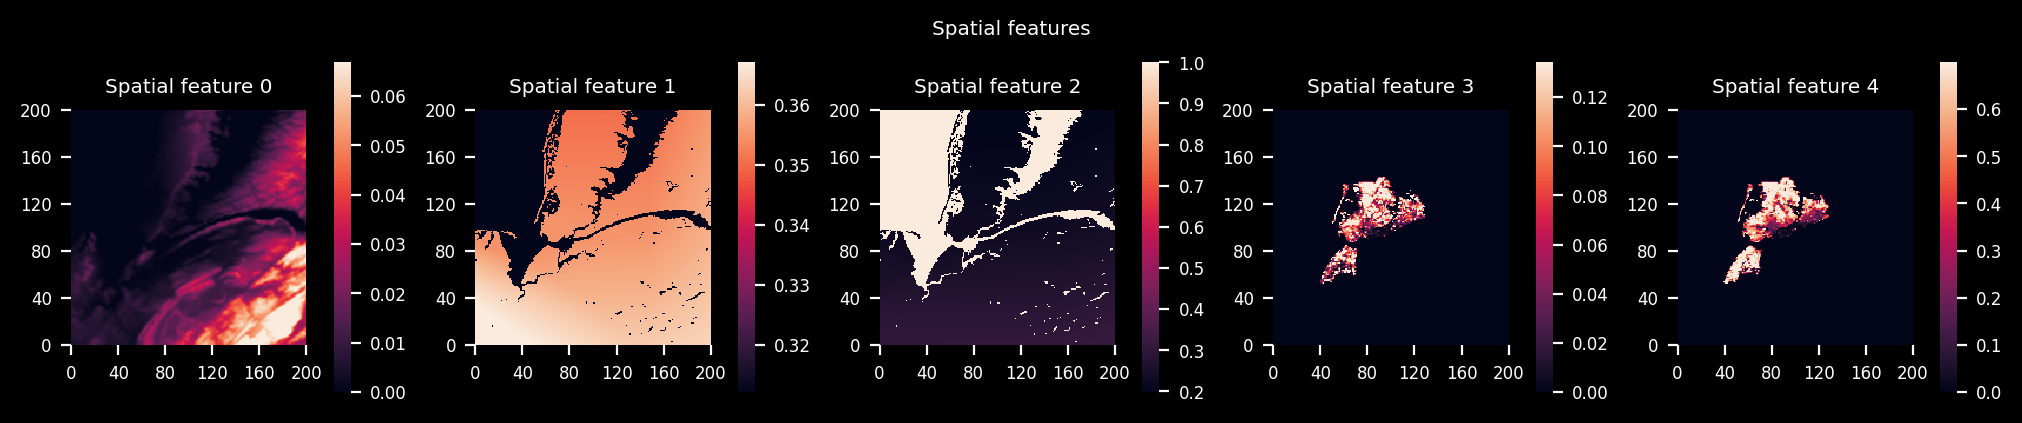

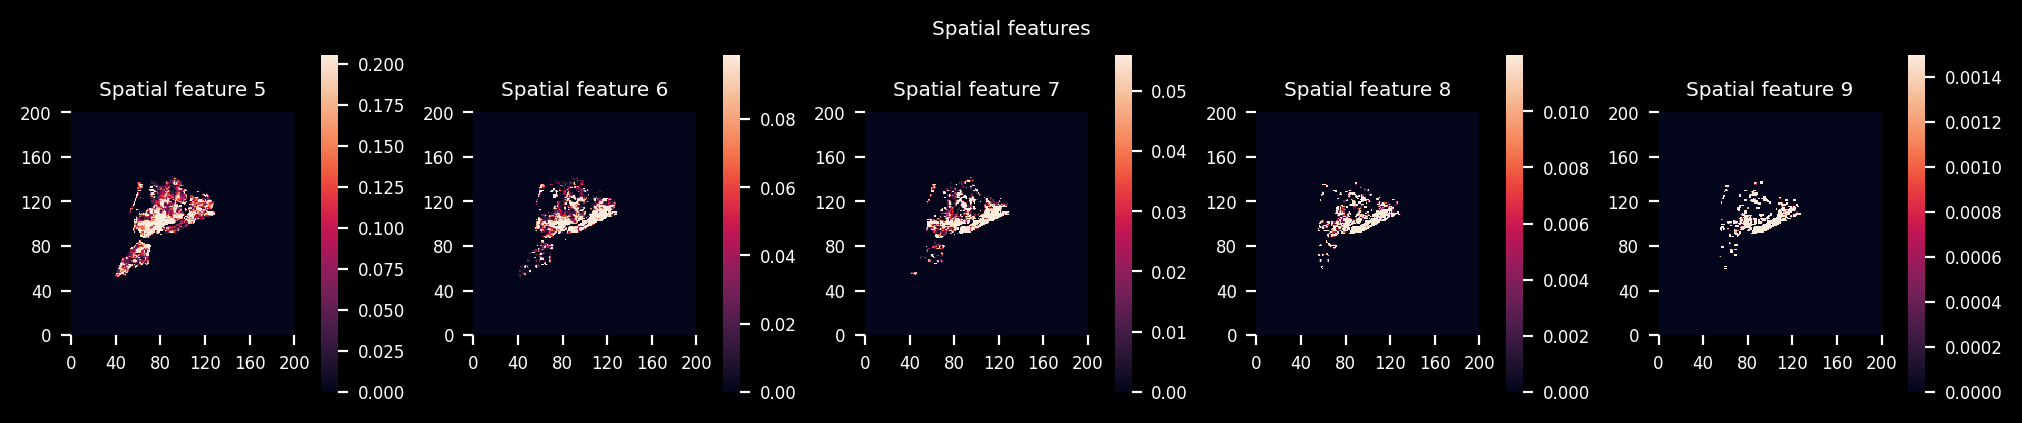

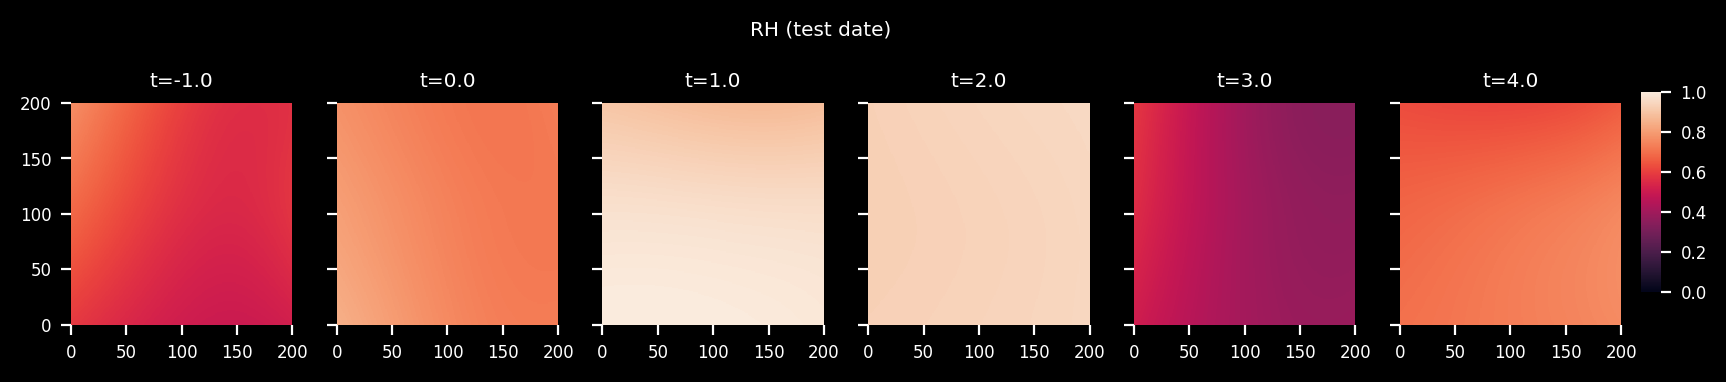

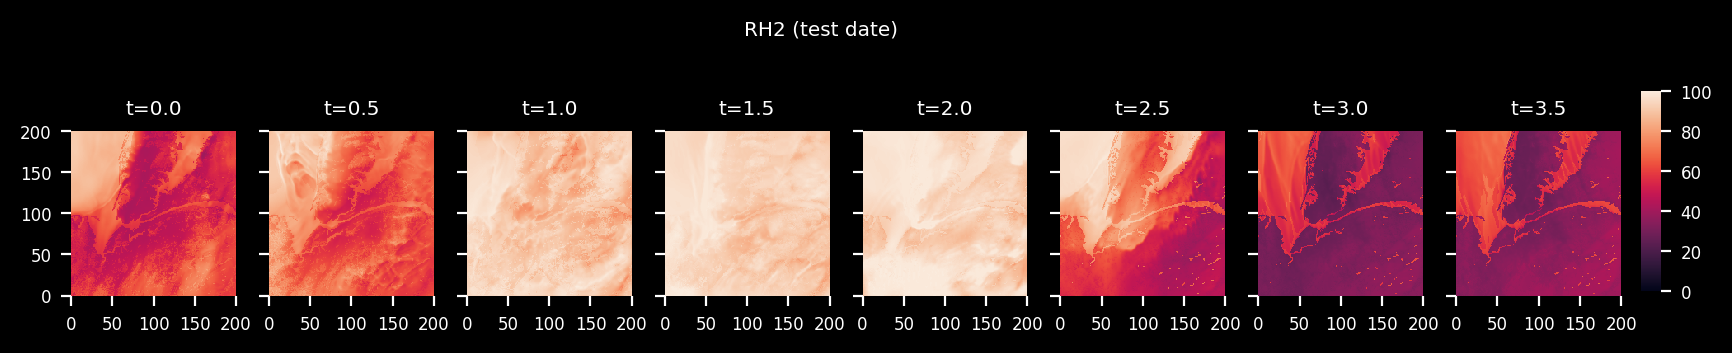

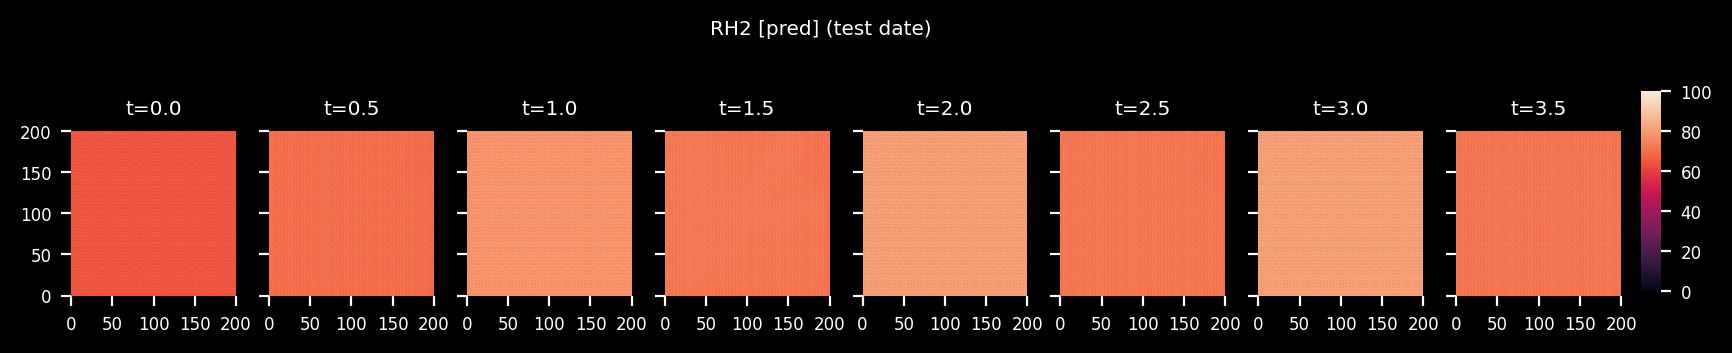

In [11]:
visualizer.init_plt()
for input_batch, label_batch in val_ds.take(1):
    preds = model.call(input_batch)
    for b, _ in enumerate(label_batch):
        figs = visualizer.plot(
            inputs={k: v[b] for k, v in input_batch.items()},
            label=label_batch[b],
            pred=preds[b],
            st_var=vars.Spatiotemporal.RH,
            sto_var=vars.SpatiotemporalOutput.RH2,
            sim_name="test",
            date="date",
        )
        for fig in figs:
            fig.show()
        break